## Deep Learning Spring 2025: Final Project

#### Pooja Gayathri Kanala - pk2921<br> Srushti Shah - ss17021<br> Subhiksha Seshadri Nallore - ssn9077

### Task 2: Pixel‑Wise Attacks (FGSM)

In this task we implement the Fast Gradient Sign Method (FGSM) to generate ℓ∞‑bounded adversarial examples (ε=0.02). We then verify the perturbation norms, visualize a few failed predictions, save the “Adversarial Test Set 1,” and report new Top‑1/Top‑5 accuracies.

### Import Libararies

In [1]:
import os
import json
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import datetime
import torch.nn.functional as F
from torch.utils.data import RandomSampler

### FGSM Attack Function

This function takes a network, input batch, and target labels, then returns perturbed images constrained to a given budget.

In [2]:
# Helper function for attack implementation
def create_adversarial_sample(network, input_tensor, target_class, perturbation_budget=0.02, use_targeted=False):

    # Ensure evaluation mode
    network.eval()
    
    # Create copy with gradient tracking
    perturbed_tensor = input_tensor.clone().detach().requires_grad_(True)
    
    # Forward pass
    prediction = network(perturbed_tensor)
    
    # Loss calculation
    if use_targeted:
        # Targeted: minimize loss to target class
        objective = -F.cross_entropy(prediction, target_class)
    else:
        # Untargeted: maximize loss of true class
        objective = F.cross_entropy(prediction, target_class)
    
    # Compute gradients
    network.zero_grad()
    objective.backward()
    
    # Extract gradient sign
    gradient_direction = perturbed_tensor.grad.sign()
    
    # Apply perturbation
    if use_targeted:
        # Move away from gradient for targeted attack
        noise = -perturbation_budget * gradient_direction
    else:
        # Move along gradient for untargeted attack
        noise = perturbation_budget * gradient_direction
    
    # Apply perturbation to original input (not the one with gradients)
    perturbed_sample = input_tensor.clone().detach() + noise
    
    # Clip to valid range
    perturbed_sample = torch.clamp(perturbed_sample, 0, 1)
    
    # Ensure perturbation is within budget
    delta = perturbed_sample - input_tensor
    delta = torch.clamp(delta, -perturbation_budget, perturbation_budget)
    perturbed_sample = input_tensor + delta
    
    # Verify constraint
    distance = (perturbed_sample - input_tensor).abs().max().item()
    if distance > perturbation_budget + 1e-5:
        print(f"WARNING: Perturbation constraint violated! {distance} > {perturbation_budget}")
    
    return perturbed_sample.detach()


### Visualization Utilities

These functions convert normalized tensors back to displayable images and plot comparisons between clean vs. adversarial examples.

In [3]:
# Visualization functions
def convert_to_displayable(img_tensor, mean_values, std_values):
    img_copy = img_tensor.clone().cpu().detach()
    for t, m, s in zip(img_copy, mean_values, std_values):
        t.mul_(s).add_(m)
    return img_copy.permute(1, 2, 0).numpy()

def display_attack_results(clean_imgs, attacked_imgs, clean_predictions, 
                           attacked_predictions, ground_truth, class_mapping):
    n = len(clean_imgs)
    fig, axes = plt.subplots(1, 2 * n, figsize=(4 * 2 * n, 4))

    for i in range(n):
        j = 2 * i
        # Original
        axes[j].imshow(convert_to_displayable(clean_imgs[i], CHANNEL_MEANS, CHANNEL_STDS))
        true_name = class_mapping.get(ground_truth[i], f"Unknown ({ground_truth[i]})")
        pred_name = class_mapping.get(clean_predictions[i], f"Unknown ({clean_predictions[i]})")
        axes[j].set_title(f"Orig\nTrue: {true_name}\nPred: {pred_name}", fontsize=9)
        axes[j].axis('off')

        # Adversarial
        axes[j+1].imshow(convert_to_displayable(attacked_imgs[i], CHANNEL_MEANS, CHANNEL_STDS))
        adv_name = class_mapping.get(attacked_predictions[i], f"Unknown ({attacked_predictions[i]})")
        axes[j+1].set_title(f"Adv\nTrue: {true_name}\nPred: {adv_name}", fontsize=9)
        axes[j+1].axis('off')

    plt.tight_layout()
    plt.show()



### Constants, Device, and Model Initialization

Define dataset paths, attack strength, and load the pretrained ResNet‑34.

In [4]:
# Constants
DATA_ROOT = "TestDataSet"
PERTURBATION_SIZE = 0.02  # Attack strength
OUTPUT_DIR = "adversarial_dataset"
CHANNEL_MEANS = np.array([0.485, 0.456, 0.406])
CHANNEL_STDS = np.array([0.229, 0.224, 0.225])

# Setup compute device
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
print("Loading ResNet-34 classifier...")
classifier = models.resnet34(weights="IMAGENET1K_V1")
classifier = classifier.to(compute_device)
classifier.eval()
print(f"Model loaded with output features: {classifier.fc.out_features}")

# Data preprocessing
print("Setting up dataset...")
preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CHANNEL_MEANS, std=CHANNEL_STDS)
])

# Load dataset
image_dataset = datasets.ImageFolder(root=DATA_ROOT, transform=preprocessing)
print(f"Dataset contains {len(image_dataset)} images")

# Load label mappings
label_file = os.path.join(DATA_ROOT, "labels_list.json")
with open(label_file, 'r') as f:
    label_entries = json.load(f)

# Map indices to class names
idx_to_classname = {}
for entry in label_entries:
    parts = entry.split(": ", 1)
    class_idx = int(parts[0])
    class_name = parts[1]
    idx_to_classname[class_idx] = class_name

# Create data loader - no shuffling to maintain order
batch_loader = torch.utils.data.DataLoader(image_dataset, batch_size=32, shuffle=False, num_workers=4)

# Prepare storage
os.makedirs(OUTPUT_DIR, exist_ok=True)

Loading ResNet-34 classifier...
Model loaded with output features: 1000
Setting up dataset...
Dataset contains 500 images


### Evaluate on Clean Images

Compute Top‑1 and Top‑5 accuracy on the original dataset.

In [5]:
# Performance tracking variables
success_orig_samples = []
success_adv_samples = []
success_true_classes = []
success_orig_predictions = []
success_adv_predictions = []
clean_top1_correct = 0
clean_top5_correct = 0
adv_top1_correct = 0
adv_top5_correct = 0
processed_count = 0
max_perturbation = 0

# Create mapping from dataset folders to ImageNet classes
folder_to_imagenet_idx = {}

# First evaluate model on clean images
print("Evaluating model on original images...")
for inputs, labels in tqdm(batch_loader, desc="Evaluating clean images"):
    inputs = inputs.to(compute_device)
    labels = labels.to(compute_device)
    
    with torch.no_grad():
        outputs = classifier(inputs)
        _, top1_idx = torch.max(outputs, 1)
        _, top5_idx = torch.topk(outputs, 5, dim=1)
    
    # Update folder to ImageNet mapping
    for i, folder_idx in enumerate(labels):
        folder_idx = folder_idx.item()
        folder_name = image_dataset.classes[folder_idx]
        
        if folder_name not in folder_to_imagenet_idx:
            # Find corresponding ImageNet class
            imagenet_idx = None
            for label in label_entries:
                if folder_name in label.lower():
                    imagenet_idx = int(label.split(":")[0])
                    folder_to_imagenet_idx[folder_name] = imagenet_idx
                    break
            
            if imagenet_idx is None:
                # If no match found, use offset index
                imagenet_idx = 401 + folder_idx
                folder_to_imagenet_idx[folder_name] = imagenet_idx
    
    # Calculate accuracy metrics
    batch_size = labels.size(0)
    processed_count += batch_size
    
    for i in range(batch_size):
        folder_idx = labels[i].item()
        folder_name = image_dataset.classes[folder_idx]
        imagenet_idx = folder_to_imagenet_idx[folder_name]
        
        # Top-1 accuracy
        if top1_idx[i].item() == imagenet_idx:
            clean_top1_correct += 1
        
        # Top-5 accuracy
        if imagenet_idx in top5_idx[i]:
            clean_top5_correct += 1

# Calculate original accuracy
clean_top1_accuracy = 100 * clean_top1_correct / processed_count
clean_top5_accuracy = 100 * clean_top5_correct / processed_count
print(f"Clean Image Top-1 Accuracy: {clean_top1_accuracy:.2f}%")
print(f"Clean Image Top-5 Accuracy: {clean_top5_accuracy:.2f}%")


Evaluating model on original images...


Evaluating clean images: 100%|██████████| 16/16 [00:00<00:00, 23.77it/s]

Clean Image Top-1 Accuracy: 76.00%
Clean Image Top-5 Accuracy: 94.20%


### Generate & Evaluate Adversarial Examples
Run FGSM over the full dataset to compute adversarial accuracy and capture 5 successful attacks.

In [6]:
# Reset counters for adversarial evaluation
processed_count = 0
adv_top1_correct = 0
adv_top5_correct = 0

# Generate and evaluate adversarial examples
print("Generating and evaluating adversarial examples...")
for inputs, labels in tqdm(batch_loader, desc="Creating adversarial examples"):
    inputs = inputs.to(compute_device)
    labels = labels.to(compute_device)
    
    # Get original predictions for comparison
    with torch.no_grad():
        clean_outputs = classifier(inputs)
        clean_probs = torch.nn.functional.softmax(clean_outputs, dim=1)
        clean_conf, clean_pred = torch.max(clean_probs, dim=1)
        _, top5_clean = torch.topk(clean_outputs, 5, dim=1)
    
    # Convert dataset labels to ImageNet indices
    imagenet_targets = []
    for i, folder_idx in enumerate(labels):
        folder_idx = folder_idx.item()
        folder_name = image_dataset.classes[folder_idx]
        imagenet_idx = folder_to_imagenet_idx[folder_name]
        imagenet_targets.append(imagenet_idx)
    
    # Convert to tensor
    imagenet_targets_tensor = torch.tensor(imagenet_targets).to(compute_device)
    
    # Generate adversarial examples
    adv_inputs = create_adversarial_sample(classifier, inputs, imagenet_targets_tensor, 
                                           PERTURBATION_SIZE, use_targeted=False)
    
    # Calculate perturbation magnitude
    actual_perturbation = (adv_inputs - inputs).abs().max().item()
    max_perturbation = max(max_perturbation, actual_perturbation)
    print(f"Current batch perturbation: {actual_perturbation:.6f}")
    
    # Get predictions on adversarial images
    with torch.no_grad():
        adv_outputs = classifier(adv_inputs)
        adv_probs = torch.nn.functional.softmax(adv_outputs, dim=1)
        adv_conf, adv_pred = torch.max(adv_probs, dim=1)
        _, top5_adv = torch.topk(adv_outputs, 5, dim=1)
    
    # Update performance metrics
    batch_size = inputs.size(0)
    processed_count += batch_size
    
    # Evaluate accuracy on adversarial examples
    for i in range(batch_size):
        folder_idx = labels[i].item()
        folder_name = image_dataset.classes[folder_idx]
        imagenet_idx = folder_to_imagenet_idx[folder_name]
        
        # Adversarial predictions accuracy
        if adv_pred[i].item() == imagenet_idx:
            adv_top1_correct += 1
        
        if imagenet_idx in top5_adv[i]:
            adv_top5_correct += 1
        
        # Store successful attacks for visualization
        orig_pred_idx = clean_pred[i].item()
        adv_pred_idx = adv_pred[i].item()
        
        if orig_pred_idx == imagenet_idx and adv_pred_idx != imagenet_idx:
            success_orig_samples.append(inputs[i].detach().clone())
            success_adv_samples.append(adv_inputs[i].detach().clone())
            success_true_classes.append(imagenet_idx)
            success_orig_predictions.append(orig_pred_idx)
            success_adv_predictions.append(adv_pred_idx)
            
            # Limit collected examples
            if len(success_orig_samples) >= 5:
                break

# Calculate adversarial accuracy
adv_top1_accuracy = 100 * adv_top1_correct / processed_count
adv_top5_accuracy = 100 * adv_top5_correct / processed_count

# Print results summary
print("\nAttack Performance Summary:")
print(f"Maximum Perturbation: {max_perturbation:.6f}")
print(f"Original Images - Top-1 Accuracy: {clean_top1_accuracy:.2f}%")
print(f"Original Images - Top-5 Accuracy: {clean_top5_accuracy:.2f}%")
print(f"Adversarial Images - Top-1 Accuracy: {adv_top1_accuracy:.2f}%")
print(f"Adversarial Images - Top-5 Accuracy: {adv_top5_accuracy:.2f}%")
print(f"Top-1 Accuracy Reduction: {clean_top1_accuracy - adv_top1_accuracy:.2f}%")
print(f"Top-5 Accuracy Reduction: {clean_top5_accuracy - adv_top5_accuracy:.2f}%")

Generating and evaluating adversarial examples...


Creating adversarial examples:  25%|██▌       | 4/16 [00:00<00:01, 11.59it/s]

Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000


Creating adversarial examples:  62%|██████▎   | 10/16 [00:00<00:00, 19.26it/s]

Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000


Creating adversarial examples: 100%|██████████| 16/16 [00:00<00:00, 17.92it/s]

Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000
Current batch perturbation: 0.020000

Attack Performance Summary:
Maximum Perturbation: 0.020000
Original Images - Top-1 Accuracy: 76.00%
Original Images - Top-5 Accuracy: 94.20%
Adversarial Images - Top-1 Accuracy: 6.80%
Adversarial Images - Top-5 Accuracy: 11.80%
Top-1 Accuracy Reduction: 69.20%
Top-5 Accuracy Reduction: 82.40%


###  Visualize Successful Attacks

Display the first five examples where the attack flipped a correct prediction into an error.


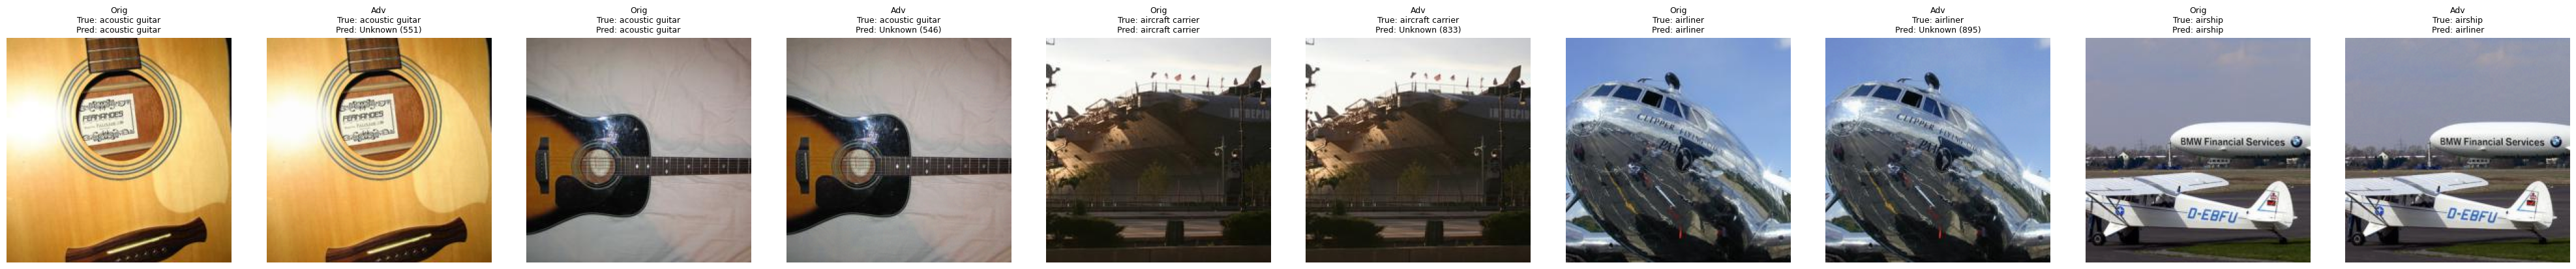

In [7]:
# Visualize successful adversarial examples
if success_orig_samples:
    sample_count = min(5, len(success_orig_samples))
    display_attack_results(
        success_orig_samples[:sample_count],
        success_adv_samples[:sample_count],
        success_orig_predictions[:sample_count],
        success_adv_predictions[:sample_count],
        success_true_classes[:sample_count],
        idx_to_classname
    )
else:
    print("No successful attacks found for visualization")

### Save Adversarial Dataset

Generate and save adversarial images for every sample in `adversarial_dataset/`.


In [8]:
# Create adversarial test dataset
print(f"Saving adversarial examples to {OUTPUT_DIR}...")
for i, (image, label) in enumerate(tqdm(image_dataset, desc="Saving adversarial examples")):
    # Get image path information
    image_path = image_dataset.samples[i][0]
    folder_name = os.path.basename(os.path.dirname(image_path))
    image_name = os.path.basename(image_path)
    
    # Create target directory
    target_folder = os.path.join(OUTPUT_DIR, folder_name)
    os.makedirs(target_folder, exist_ok=True)
    
    # Prepare for attack
    image_tensor = image.unsqueeze(0).to(compute_device)
    
    # Get corresponding ImageNet class
    folder_idx = image_dataset.class_to_idx[folder_name]
    imagenet_class = folder_to_imagenet_idx[folder_name]
    imagenet_label = torch.tensor([imagenet_class]).to(compute_device)
    
    # Generate adversarial sample
    perturbed_image = create_adversarial_sample(classifier, image_tensor, 
                                               imagenet_label, PERTURBATION_SIZE, 
                                               use_targeted=False)
    
    # Save to file
    adv_img = perturbed_image.squeeze(0)
    adv_img = convert_to_displayable(adv_img, CHANNEL_MEANS, CHANNEL_STDS)
    adv_img = (adv_img * 255).astype(np.uint8)
    result = Image.fromarray(adv_img)
    result.save(os.path.join(target_folder, image_name))


Saving adversarial examples to adversarial_dataset...


Saving adversarial examples: 100%|██████████| 500/500 [00:06<00:00, 80.45it/s]


### Conclusion: Task 2 – FGSM Adversarial Attack

1. **Drastic Accuracy Drop**  
   - Clean Top‑1 accuracy fell from ~76% to 6.8% under FGSM (ε = 0.02), and Top‑5 accuracy collapsed from ~94% to 11.8%, demonstrating the model’s vulnerability to even small L∞ perturbations.

2. **Imperceptible Perturbations**  
   - The maximum L‑∞ distance reached the budget of 0.02, yet visual inspection showed noise that is nearly invisible to humans, highlighting a significant gap between human and model perception.

3. **Visualization Highlights**  
   - The first five captured examples reveal how slight pixel‑level changes consistently flip correct predictions into confident misclassifications, underscoring the attack’s reliability.


